# Feature engineering

- Создание новых признаков - трудоемкий процесс, который позволяет значительно повысить точность модели при правильном использовании методов создания новых признаков.
- Самое большое повышение точности обычно случается после того, как Data Science разработчик погружается в предметную область задачи, потому что это позволяет создавать новые признаки осмысленно.  
- Несмотря на это, есть автоматические/полуавтоматические методы создания новых признаков, о которых мы поговорим ниже.  
- Для исследования темы создания новых признаков воспользуемся датасетом `vis_data` и дополним его новой информацией:

In [1]:
import os; os.listdir()

['latlons.csv.xls',
 'm2_part4_feature_engineering.ipynb',
 'train.csv',
 '.ipynb_checkpoints',
 'Untitled.ipynb']

In [194]:
import numpy as np
import pandas as pd
%matplotlib inline

vis_data = pd.read_csv("train.csv", 
                       encoding = 'ISO-8859-1', 
                       low_memory = False)
vis_data = vis_data.drop(['violation_zip_code', 'clean_up_cost'], axis=1)

# добавим координаты правонарушения в vis_data
latlons = pd.read_csv("latlons.csv.xls")
display(latlons.head())
vis_data = pd.concat([vis_data, latlons], axis=1)

,address,lat,lon
0,"4300 rosa parks blvd, Detroit MI 48208",42.346169,-83.079962
1,"14512 sussex, Detroit MI",42.394657,-83.194265
2,"3456 garland, Detroit MI",42.373779,-82.986228
3,"5787 wayburn, Detroit MI",42.403342,-82.957805
4,"5766 haverhill, Detroit MI",42.407255,-82.946295


## 1. Ручное создание признаков

- **Ручное создание признаков** требует погружения в предметную область задачи и не всегда гарантирует положительный результат.  
- Часто данные приходят без пояснения и есть только сами табличные данные и, если повезет, названия признаков.
- Нам повезло. Посмотрим на данные и на названия признаков:

In [91]:
vis_data.head(2)

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,non_us_str_code,country,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance,address,lat,lon,distance,is_weekend,wd
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,3.0,S. WICKER,other,IL,60606,NaN,USA,2004-03-16 11:40:00,2005-03-21 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,250.0,20.0,10.0,25.0,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,"4300 rosa parks blvd, Detroit MI 48208",42.346169,-83.079962,3.254559,False,1
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,2959.0,Martin Luther King,detroit,MI,48208,NaN,USA,2004-04-23 12:30:00,2005-05-06 13:30:00,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Determination,750.0,20.0,10.0,75.0,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0,"14512 sussex, Detroit MI",42.394657,-83.194265,14.082448,False,4


In [92]:
# Выведим список наших признаков
vis_data.columns

Index(['ticket_id', 'agency_name', 'inspector_name', 'violator_name',
       'violation_street_number', 'violation_street_name',
       'mailing_address_str_number', 'mailing_address_str_name', 'city',
       'state', 'zip_code', 'non_us_str_code', 'country', 'ticket_issued_date',
       'hearing_date', 'violation_code', 'violation_description',
       'disposition', 'fine_amount', 'admin_fee', 'state_fee', 'late_fee',
       'discount_amount', 'judgment_amount', 'payment_amount', 'balance_due',
       'payment_date', 'payment_status', 'collection_status',
       'grafitti_status', 'compliance_detail', 'compliance', 'address', 'lat',
       'lon', 'distance', 'is_weekend', 'wd'],
      dtype='object')

- Судя по названию переменных, это **данные о нарушителях**, которые должны платить штраф за какое-то правонарушение.  
- Есть переменная **compliance**, которая принимает значения `0`, `1` и `None`.
Так как описания нет, мы можем предположить, что 0 - нарушитель заплатил штраф, 1 - не заплатил. Что в данном контексте означает None понять трудно, возможно, это пропуски, которые следует просто выбросить.  

- Кроме изначальных признаков нам также дали ширину и долготу. Также, есть признак `city`. Что можно сделать с таким набором признаков? 

- Например, можно посмотреть расстояние от точки правонарушения до центра города, в котором произошло нарушение. Давайте сначала исследуем, какие города представлены в выборке:

In [195]:
# Можно посмотреть на value_counts, не ограничивая вывод, 
# чтобы увидеть, как много там разных значений
vis_data.city.value_counts()[:10]

DETROIT             136936
SOUTHFIELD           13436
Detroit              10496
detroit               4183
DEARBORN              3637
FARMINGTON HILLS      2329
OAK PARK              2216
WARREN                2000
DET                   1657
W. BLOOMFIELD         1635
Name: city, dtype: int64

У нас грязные данные:

- Видно, что подавляюще большую часть значений составляет `DETROIT`. Также, чуть ниже видны `Detroit` и `detroit`.  
- Название города с самым большим количеством нарушений записано по-разному в данных. 
- Возможно, некоторые другие города тоже записаны в разном регистре.  

In [196]:
# нормализируем данные, приводим их к нижнему регистру
vis_data.city = vis_data.city.apply(lambda x: x.lower())

In [197]:
vis_data.city.value_counts()[:10]

detroit             151621
southfield           14760
dearborn              4017
farmington hills      2508
oak park              2432
warren                2150
det                   1928
livonia               1798
w. bloomfield         1795
redford               1718
Name: city, dtype: int64

Обработав данные:

- Теперь мы более точно видим, что большинство преступлений (из представленных в выборке) совершается в Детройте.  
Возможно, информативным признаком будет расстояние от места правонарушения до центра Детройта.  

Добавим новый признак, расстояние до Детройда

- Теперь давайте найдем для каждого нарушения, для которого есть широта и долгота, его расстояние **до центра Детройта** со следующими координатами:
 - широта: 42.331429
 - долгота: -83.045753

In [198]:
from math import radians, sin, cos, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2) ** 2
    c = 2 * asin(sqrt(a))
    earth_radius = 6371 
    return c * earth_radius

vis_data['distance'] = vis_data.apply(lambda row: 
                                      haversine(lon1 = -83.045753, 
                                                lat1 = 42.331429,
                                                lon2 = row['lon'], 
                                                lat2 = row['lat']), 
                                      axis=1)

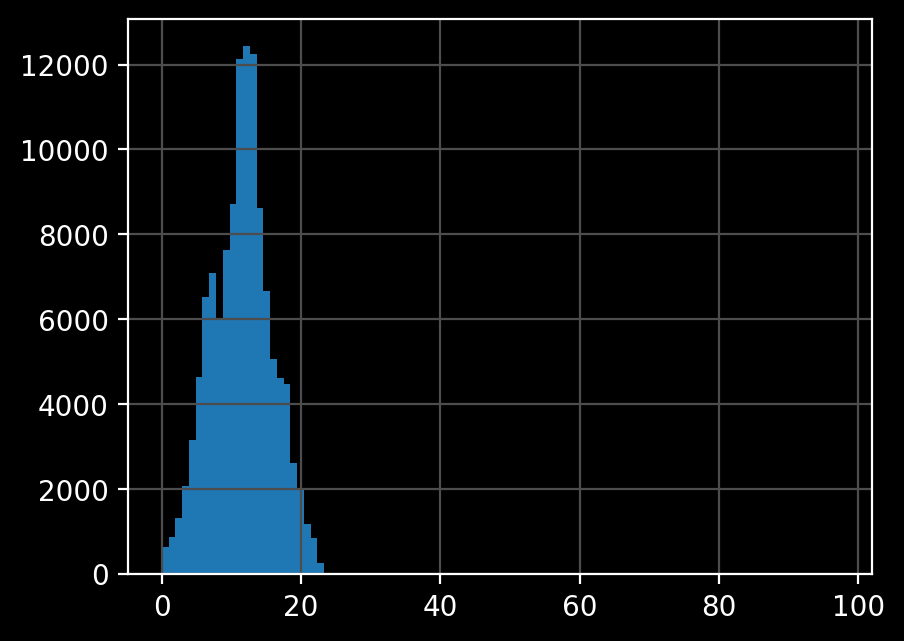

In [199]:
vis_data['distance'][vis_data['distance'] < 100].hist(bins=100);

## 2. Создание полиномиальных признаков

- Теперь рассмотрим более механические и менее интеллектуальные способы создать признаки. Новые признаки можно создавать, просто перемножением и делением старых признаков друг на друга.  
- Кроме этого, можно брать один признак и возводить его, например, в квадрат или брать из него корень. 
- То есть, в более общем виде, можно создать новый признак из старого, возведя все значения старого признака в дробную степень.

In [200]:
from sklearn.preprocessing import PolynomialFeatures

Класс `PolynomialFeatures` из библиотеки `sklearn` принимает на вход набор признаков и на выходе отдает полиномиальные признаки, сгенерированные на основе входных и со степенью меньше либо равной указанной.  
Например, для признаков `[a, b]` и степени `2` он вернет `[1, a, b, a^2, ab, b^2]`.

In [202]:
model = PolynomialFeatures(2)

In [203]:
# Создадим полиномиальные признаки для некоторых признаков
subset = vis_data[['balance_due', 'payment_amount']]
poly_features = model.fit_transform(subset)
poly_features

array([[1.0000e+00, 3.0500e+02, 0.0000e+00, 9.3025e+04, 0.0000e+00,
        0.0000e+00],
       [1.0000e+00, 7.5000e+01, 7.8000e+02, 5.6250e+03, 5.8500e+04,
        6.0840e+05],
       [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

In [204]:
poly_features.shape

(250306, 6)

## 3. Dummy-переменные

Когда мы говорим о **категориальных признаках**, есть два основных случая:
 - Категориальный признак содержит строки, никакая модель не примет их на вход, потребуется некоторое преобразование
 - Категориальный признак содержит числа. В таком случае, в принципе, можно никак не трогать этот признак, но это будет неправильно с точки зрения логики обучения модели.
 
Рассмотрим второй случай: есть признак "тип животного", который принимает `n` различных значений: значение 0, если животное - кошка, 1 - если тигр, 2 - если пантера. В отличие от `continuous` признаков, то есть, имеющих некоторый порядок, категориальные признаки такого порядка не имеют - мы не можем строго сравнить тигра и пантеру, это просто разные сущности. Некоторые алгоритмы могут работать с категориальными признаками, некоторые - нет.  
Естественной предобработкой для таких признаков является создание dummy-переменных на основе категориального признака, то есть, создание `n` признаков-индикаторов. Каждый из индикаторов равен 1 тогда, когда в изначальном примере выбрано соответствующее значение и 0 иначе. 

Dummy переменные для признака `state`

- Преобразуем признак `state` в dummy-переменные и посмотрим его `shape`:

In [207]:
vis_data['state'].value_counts().index

Index(['MI', 'CA', 'TX', 'FL', 'IL', 'SC', 'OH', 'NY', 'MN', 'GA', 'NV', 'UT',
       'PA', 'NJ', 'VA', 'NC', 'MD', 'AZ', 'ME', 'OK', 'AL', 'TN', 'WA', 'MA',
       'WI', 'IA', 'OR', 'MO', 'CO', 'KY', 'IN', 'AR', 'LA', 'AK', 'NB', 'UK',
       'MS', 'CT', 'DC', 'ON', 'DE', 'KS', 'RI', 'SD', 'ID', 'MT', 'NM', 'BC',
       'WY', 'HI', 'NH', 'VT', 'VI', 'WV', 'PR', 'QC', 'QL', 'ND', 'BL'],
      dtype='object')

In [208]:
pd.get_dummies(vis_data.state).shape

(250306, 59)

Dummy переменные для признака `city`

Теперь преобразуем признак `city` в dummy-переменные. Для этого сначала требуется сделать небольшую предобработку, чтобы сократить количество уникальных значений в этом признаке. Для начала, найдем города, которые описывают большинство (`90%`) примеров:

In [213]:
# В данном признаке слишком много городов для OHE
vis_data['city'].value_counts().index

Index(['detroit', 'southfield', 'dearborn', 'farmington hills', 'oak park',
       'warren', 'det', 'livonia', 'w. bloomfield', 'redford',
       ...
       'new yrok', 'brown stown', 'charlton   london', 'glenallen', 'aliso',
       'boco  raton', 'wbfd', 'schraumberg', 'atlantic  mine', 'angola'],
      dtype='object', length=4324)

In [214]:
cities_with_freqs = list(vis_data.city.value_counts())

In [215]:
top_cities_count = int(np.percentile(cities_with_freqs, 90))
top_cities_count

14

- Теперь оставим только этот топ городов, **остальные города** назовем `other`:

In [216]:
all_cities = vis_data.city.value_counts().index
top_cities = list(all_cities)[:top_cities_count]
cities_to_throw_away = list(set(all_cities) - set(top_cities))
vis_data.loc[vis_data['city'].isin(cities_to_throw_away), 
             'city'] = 'other'

Теперь количество уникальных значений в признаке `city` сократилось до:

In [217]:
len(vis_data.city.value_counts())

15

- Можем создать dummy-признаки для этой переменной:

In [187]:
pd.get_dummies(vis_data.city, drop_first=True).head()

,dearborn,det,detroit,eastpointe,farmington hills,livonia,oak park,other,redford,southfield,troy,w. bloomfield,warren,west bloomfield
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0


## 3. Работа с датой/временем

- `Pandas` поддерживает работу с датами.  
[Больше про работу с временем в pandas](https://codeburst.io/dealing-with-datetimes-like-a-pro-in-pandas-b80d3d808a7f)  
- Выберем признак, содержащий время, уберем пропуски и преобразуем его в специальный формат для работы со временем:

In [220]:
datetime_vals = pd.to_datetime(vis_data.payment_date.dropna())

In [221]:
datetime_vals.head()

1    2005-06-02
11   2005-03-17
15   2005-02-11
18   2005-03-18
19   2005-03-18
Name: payment_date, dtype: datetime64[ns]

Теперь к этим значениям можно обращаться для **определения дня, месяца или года**

In [222]:
# Как один пример 
datetime_vals[1].month

6

Кроме этого, можно вытаскивать такие признаки, как **день недели:**

In [223]:
datetime_vals[1].weekday()

3

- Отсчет начинается с понедельника и с нуля, поэтому мы понимаем, что это четверг.  
- Почему это может быть важным признаком? 
- Например, в текущем наборе данных можно использовать такой признак как будний день/выходной, чтобы определить, когда чаще совершают правонарушения:

In [192]:
dt_issued_date = pd.to_datetime(vis_data.ticket_issued_date)

# Создаем новые признаки 
vis_data['is_weekend'] = dt_issued_date.dt.weekday > 4
vis_data['wd'] = dt_issued_date.dt.weekday

Здесь мы воспользовались специальным селектором `dt`, который для удобства содержит методы для работы со временем в `pandas`.  

## 4. Статистики по наборам признаков

Одним из интересных способов использовать данные для создания новых признаков является расчет различных статистик по данным.  
Примерами статистик могут быть минимум, максимум, стандартное отклонение и многие другие.  
Этот способ работает, если в данных содержится, помимо прочих признаков, некоторое подобие временных рядов.  
Например, примеры - это продукты, а зависимая переменная - купит ли покупатель этот продукт. Признаками, которые нас интересуют, будут стоимость данного продукта за 2015, 2016 и 2017 годы. В таком случае мы можем взять среднее, медиану, максимум, минимум и что угодно еще по этим трем столбцам и получить множество новых признаков.  
Не факт, что данные признаки будут полезны, это мы увидим на этапе валидации и тестирования. Но часто такие признаки действительно оказываются полезными.